In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings

warnings.filterwarnings('ignore')

d:\Anaconda\envs\DataScience\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Anaconda\envs\DataScience\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
d:\Anaconda\envs\DataScience\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
data = pd.read_csv("../data/keyword_jptiik.csv")

data_abs = data[["abstract"]]
data_abs.head()

,abstract
0,teknologi mixed reality akan membuat interaksi...
1,penjadwalan merupakan salah satu proses pentin...
2,untuk memenuhi kebutuhan masyarakat akan keter...
3,perusahaan mcdonald’s adalah perusahaan yang b...
4,perkembangan internet saat ini sangat pesat. d...


In [3]:
data_abs["abstract"] = data_abs["abstract"].str.strip()
data_abs["abstract"] = data_abs["abstract"].str.lower()
data_abs["abstract"] = data_abs["abstract"].str.replace('[^\w\s]','')
data_abs["abstract"] = data_abs["abstract"].str.replace('\d+', '')
data_abs["abstract"] = data_abs["abstract"].str.replace('\s+', ' ')
data_abs["abstract"] = data_abs["abstract"].str.replace('\n', ' ')
data_abs["abstract"] = data_abs["abstract"].str.replace('\t', ' ')
data_abs["abstract"] = data_abs["abstract"].str.replace('  ', ' ')

In [4]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [5]:
stopword = StopWordRemoverFactory().create_stop_word_remover()
stemmer = StemmerFactory().create_stemmer()

data_abs["abstract"] = data_abs["abstract"].apply(lambda x: stopword.remove(x))
data_abs["abstract"] = data_abs["abstract"].apply(lambda x: stemmer.stem(x))

In [6]:
import random

In [7]:
vocab = set()
max_tokens = 10000

for abstract in data_abs["abstract"]:
    for word in abstract.split():
        vocab.add(word)
    
vocab = list(vocab)
random.shuffle(vocab)
vocab = vocab[:max_tokens]
vocab += ["<UNK>"]

data_abs["abstract"] = data_abs["abstract"].apply(lambda x: x.split())
data_abs["abstract"] = data_abs["abstract"].apply(lambda x: [word if word in vocab else "<UNK>" for word in x])
data_abs["abstract"] = data_abs["abstract"].apply(lambda x: " ".join(x))

word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for idx, word in enumerate(vocab)}

In [8]:
data_abs["abstract"] = data_abs["abstract"].apply(lambda x: [word2idx[word] for word in x.split()])

In [9]:
# mean length of abstract
MAX_LENGTH = round(sum([len(abstract) for abstract in data_abs["abstract"]]) / len(data_abs["abstract"]))

# padding and truncate
data_abs["abstract"] = data_abs["abstract"].apply(lambda x: x + [0] * (MAX_LENGTH - len(x)) if len(x) < MAX_LENGTH else x[:MAX_LENGTH])
# data_abs["abstract"] = data_abs["abstract"].apply(lambda x: torch.tensor(x).float())

In [10]:
data_abs = data_abs["abstract"].apply(pd.Series)
data_abs

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
0,10000,8722,10000,7962,10000,2274,10000,7713,6913,3733,...,0,0,0,0,0,0,0,0,0,0
1,7765,3517,10000,10000,10000,7929,10000,10000,7765,10000,...,0,0,0,0,0,0,0,0,0,0
2,10000,954,7273,2966,10000,6139,10000,8560,6745,10000,...,0,0,0,0,0,0,0,0,0,0
3,9217,6781,9217,10000,3883,7363,3162,4345,9374,6781,...,10000,551,10000,551,10000,6781,3688,10000,6625,7485
4,6139,10000,1162,10000,6062,4710,6139,10000,1248,10000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,10000,10000,5756,10000,10000,10000,4347,9217,8903,10000,...,10000,10000,10000,10000,41,10000,10000,1235,10000,10000
3475,8022,10000,2929,4101,8770,8022,10000,4168,8858,10000,...,8034,8204,8034,761,8204,10000,2632,4332,8034,10000
3476,10000,10000,7140,2976,10000,10000,10000,10000,10000,10000,...,2727,3689,1870,10000,8034,5101,10000,10000,10000,10000
3477,3809,10000,4209,10000,8071,2031,3957,10000,10000,8486,...,7905,10000,2331,5663,9976,9461,9976,10000,10000,10000


In [11]:
data_abs.shape

(3479, 109)

In [12]:
VOCAB_SIZE = len(vocab)

In [ ]:
data_abs = data_abs.to_numpy()
data_abs = torch.tensor(data_abs).float()
data_abs

In [52]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, 109)
        self.fc1 = nn.Linear(109, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        # self.fc5 = nn.Linear(8, 4)
        # self.fc6 = nn.Linear(4, 2)
        self.tanh = nn.Tanh()
        self.gelu = nn.GELU()
        self.relu = nn.ReLU()

    
    def forward(self, x):
        x = self.embedding(x)
        embed = x.clone()
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.fc3(x)
        x = self.gelu(x)
        x = self.fc4(x)
        # x = self.gelu(x)
        # x = self.fc5(x)
        # x = self.gelu(x)
        # x = self.fc6(x)

        return x, embed
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # self.fc6 = nn.Linear(2, 4)
        # self.fc5 = nn.Linear(4, 8)
        self.fc4 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc1 = nn.Linear(64, 109)
        self.like_embedding = nn.Linear(109, 109)
        # self.embedding = nn.Embedding(109, VOCAB_SIZE) # I'm not sure..
        self.tanh = nn.Tanh()
        self.gelu = nn.GELU()
        self.selu = nn.SELU()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # x = self.fc6(x)
        # x = self.gelu(x)
        # x = self.fc5(x)
        # x = self.gelu(x)
        x = self.fc4(x)
        x = self.gelu(x)
        x = self.fc3(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.fc1(x)
        x = self.like_embedding(x)
        # x = x.type(torch.LongTensor)
        # x = self.embedding(x)

        return x

class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        out_encoder = self.encoder(x)
        x = out_encoder[0]
        embed_enc = out_encoder[1]
        x = self.decoder(x)
        return x, embed_enc

In [53]:
E = Encoder()
D = Decoder()

a = E(data_abs[0].type(torch.LongTensor))
a[1].shape # embed

torch.Size([109, 109])

In [54]:
D(a[0]).shape # decode that mimick embedding

torch.Size([109, 109])

In [57]:
E = Encoder()
D = Decoder()
AE = AutoEncoder(E, D)

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(AE.parameters(), lr=0.01)

for epoch in range(200):
    
    abstract = data_abs.type(torch.LongTensor)
    optimizer.zero_grad()
    output = AE(abstract)
    loss = criterion(output[0], output[1])
    loss.backward()
    optimizer.step()
    print(loss)

tensor(0.4436, grad_fn=<SmoothL1LossBackward0>)
tensor(0.4209, grad_fn=<SmoothL1LossBackward0>)
tensor(0.3996, grad_fn=<SmoothL1LossBackward0>)
tensor(0.3825, grad_fn=<SmoothL1LossBackward0>)
tensor(0.3674, grad_fn=<SmoothL1LossBackward0>)
tensor(0.3364, grad_fn=<SmoothL1LossBackward0>)
tensor(0.3092, grad_fn=<SmoothL1LossBackward0>)
tensor(0.2968, grad_fn=<SmoothL1LossBackward0>)
tensor(0.2749, grad_fn=<SmoothL1LossBackward0>)
tensor(0.2956, grad_fn=<SmoothL1LossBackward0>)
tensor(0.2637, grad_fn=<SmoothL1LossBackward0>)
tensor(0.2750, grad_fn=<SmoothL1LossBackward0>)
tensor(0.2645, grad_fn=<SmoothL1LossBackward0>)
tensor(0.2470, grad_fn=<SmoothL1LossBackward0>)
tensor(0.2470, grad_fn=<SmoothL1LossBackward0>)
tensor(0.2449, grad_fn=<SmoothL1LossBackward0>)
tensor(0.2317, grad_fn=<SmoothL1LossBackward0>)
tensor(0.2293, grad_fn=<SmoothL1LossBackward0>)
tensor(0.2282, grad_fn=<SmoothL1LossBackward0>)
tensor(0.2224, grad_fn=<SmoothL1LossBackward0>)
tensor(0.2143, grad_fn=<SmoothL1LossBack

kayaknya masih ada yang salah.. kita gak bisa mengoreksi bobot embeddingnya.. kita cuma menyamakan embedding input dan output. Jadinya ga ke update. Kayaknya ini waktunya pake embedding yang udah ke pretrained.

In [64]:
latent_representation = AE.encoder(data_abs.type(torch.LongTensor))[0].view(3479, -1)
latent_representation.shape     

torch.Size([3479, 872])

In [65]:
# to dataframe
latent_df = pd.DataFrame(latent_representation.detach().numpy())
latent_df

,0,1,2,3,4,5,6,7,8,9,...,862,863,864,865,866,867,868,869,870,871
0,-2.909524,-1.045589,3.733477,2.082808,0.354087,1.042934,-0.005766,-0.975246,0.263878,-0.185824,...,-0.557950,-3.946592,3.926192,-3.219632,0.091104,-0.256804,0.600754,-1.113502,-0.557950,-3.946592
1,-0.677134,0.466286,-0.342529,-0.350080,-0.195850,-0.078918,-0.159382,0.460928,0.738794,-0.873918,...,-0.557950,-3.946592,3.926192,-3.219632,0.091104,-0.256804,0.600754,-1.113502,-0.557950,-3.946592
2,-2.909524,-1.045589,3.733477,2.082808,0.354087,1.042934,-0.005766,-0.975246,1.054779,-0.931933,...,-0.557950,-3.946592,3.926192,-3.219632,0.091104,-0.256804,0.600754,-1.113502,-0.557950,-3.946592
3,-0.094841,-0.080950,-0.043430,-0.070291,-0.140706,0.022876,0.215967,-0.024575,-1.326429,0.298473,...,0.215673,-0.196002,-0.450278,-0.294705,0.612611,0.290573,-0.043806,0.206302,0.235951,-0.306681
4,-1.101353,0.816758,-0.719182,-1.012418,-0.556274,-0.440139,-1.292661,1.473974,-2.909524,-1.045589,...,-0.557950,-3.946592,3.926192,-3.219632,0.091104,-0.256804,0.600754,-1.113502,-0.557950,-3.946592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,-2.909524,-1.045589,3.733477,2.082808,0.354087,1.042934,-0.005766,-0.975246,-2.909524,-1.045589,...,-0.005766,-0.975246,-2.909524,-1.045589,3.733477,2.082808,0.354087,1.042934,-0.005766,-0.975246
3475,-0.417759,-0.286526,0.570342,0.265416,-0.050105,0.197197,0.236762,-0.295660,-2.909524,-1.045589,...,-1.314973,1.541642,-2.909524,-1.045589,3.733477,2.082808,0.354087,1.042934,-0.005766,-0.975246
3476,-2.909524,-1.045589,3.733477,2.082808,0.354087,1.042934,-0.005766,-0.975246,-2.909524,-1.045589,...,-0.005766,-0.975246,-2.909524,-1.045589,3.733477,2.082808,0.354087,1.042934,-0.005766,-0.975246
3477,-1.054839,0.784879,-0.487864,-0.607101,-0.191154,-0.091924,-0.545621,0.702808,-2.909524,-1.045589,...,-0.005766,-0.975246,-2.909524,-1.045589,3.733477,2.082808,0.354087,1.042934,-0.005766,-0.975246


In [66]:
JUMLAH_PEMINATAN = 6
k_means = KMeans(n_clusters=JUMLAH_PEMINATAN).fit(latent_representation.detach().numpy())
labels = k_means.labels_

In [67]:
data["labels"] = labels

In [68]:
data["labels"].value_counts()

2    1216
1    1054
3     490
5     356
4     184
0     179
Name: labels, dtype: int64

In [69]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_representation.detach().numpy())

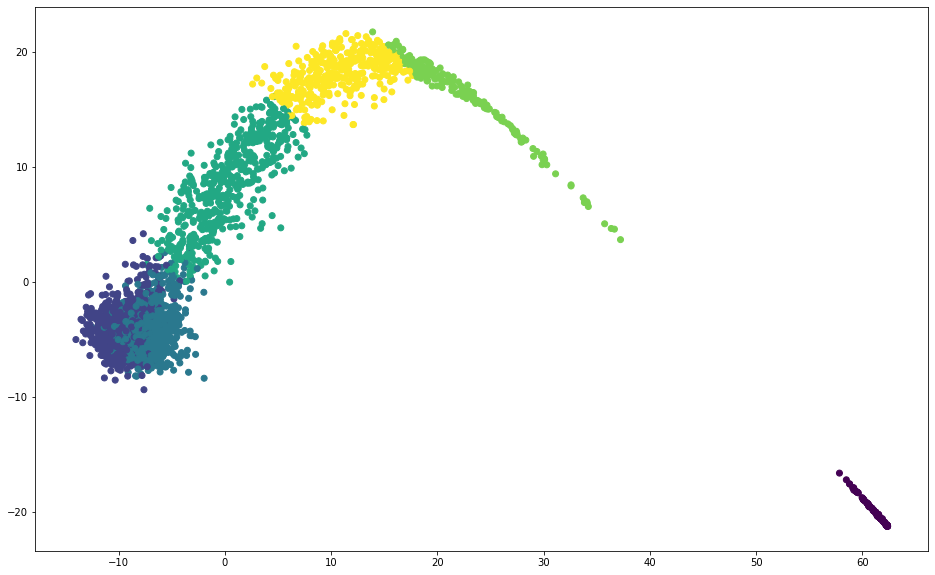

In [70]:
plt.figure(figsize=(16,10))
plt.scatter(pca_result[:,0], pca_result[:,1], c=labels)
plt.show()

In [72]:
data.to_csv("../data/cluster_poc embed_jptiik.csv", index=False)

In [73]:
torch.save(AE, "../model/full_ae_poc embed_jptiik.pt")

In [74]:
model2 = torch.load("../model/full_ae_poc embed_jptiik.pt")

In [75]:
data[data["labels"] == 1]["keywords"].values[0]

"['jenis layanan', 'delivery order', 'zero complaint', 'menerapkan konsep', 'melaporkan data', 'dimiliki mcdonald', 'outlet mcdonald', 'outlet-outlet', 'menampilkan chart', 'kualitas pelayanan']"

In [76]:
data[data["labels"] == 1]["keywords"].values[2]


"['one-cut-point crossover', 'teknik crossover', 'bervariasi menyebabkan', 'menghasilkan keputusan', 'algoritma genetika', 'representasi kromosom', 'real-coded', 'random mutation', 'perbaikan kromosom', 'korelasi spearman']"